In [2]:
!pwd # checking current working directory

/kaggle/working


In [5]:
# importing useful libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [6]:
# loading in the training classes, it is a dataframe mapping of image name to tags
train_classes_df = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/train_classes.csv")
print(train_classes_df.shape)
train_classes_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# let's check the color channels in a randomly selected image...say the image with image_name 'train_10.jpg'
train_img10 = image.load_img("/kaggle/input/planets-dataset/planet/planet/train-jpg/train_10.jpg")
train_img10.mode # checking the color channels 

'RGB'

In [8]:
!ls "/kaggle/input/planets-dataset/planet/planet/train-jpg/" | wc -l # checking the total number of images in the
     

40479


In [9]:
test1 = !ls "/kaggle/input/planets-dataset/planet/planet/test-jpg/" | wc -l # checking total number of images in 
                                                                            # testing images folder
float(test1[0])

40669.0

In [10]:
# checking total number of images in the testing images additional folder
test_additional = !ls "/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/" | wc -l
float(test_additional[0])

20522.0

In [11]:
# loading and checking the sample submission dataframe
sample_submission = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/sample_submission.csv")
print(sample_submission.shape)
sample_submission.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [12]:
# let's confirm that the sum of image files in the testing and testing-additional equals the number of images in
# the sample submission dataframe
assert sample_submission.shape[0] == float(test1[0]) + float(test_additional[0])

## Let's find the unique tags in train_classes data
* First, we create a function that adds elements of a list to a Set
* Secondly, we apply this function to the tags column of train_classes after splitting its values to a list

In [13]:
# casting 'unique_labels' as a list because set isn't an indexed data structure
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels) 

In [14]:
print(unique_labels)
len(unique_labels)

['clear', 'partly_cloudy', 'blooming', 'cultivation', 'haze', 'agriculture', 'water', 'habitation', 'selective_logging', 'artisinal_mine', 'cloudy', 'primary', 'slash_burn', 'conventional_mine', 'bare_ground', 'road', 'blow_down']


17

#### Let's vectorize (one hot encode) the tags in train_classes using unique_labels

In [15]:
# let's confirm that there is no image_name duplicate in the 'train_classes' dataframe
assert len(train_classes['image_name'].unique()) == train_classes.shape[0]

In [16]:
# let's do one hot encoding (vectorize) the labels in 'train_classes'
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,clear,partly_cloudy,blooming,cultivation,haze,agriculture,water,habitation,selective_logging,artisinal_mine,cloudy,primary,slash_burn,conventional_mine,bare_ground,road,blow_down
0,train_0.jpg,haze primary,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
2,train_2.jpg,clear primary,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,train_3.jpg,clear primary,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0


<AxesSubplot:>

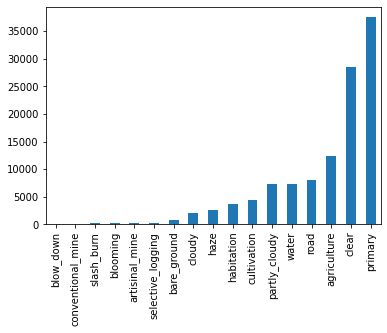

In [17]:
# an histogram of the number of tags
train_classes[unique_labels].sum().sort_values().plot.bar() 

In [18]:
# creating a function that generates a concurrent matrix (a matrix that contains the number of overlaps of pairs
# of tags)
def get_concurrent_matrix(tags):
    concur_df = train_classes[tags]
    concur_matrix = concur_df.T.dot(concur_df)
    mask = np.triu(np.ones((len(tags), len(tags))))
    sns.heatmap(concur_matrix, cmap=sns.cm.rocket_r, mask=mask)
    
    return concur_matrix

In [19]:
# classifying the tags into the three categories of 'atmospheric condition', 'common land cover' and 
# 'rare land cover'
atm_condition_tags = ['clear', 'partly_cloudy','cloudy', 'haze']
common_land_cover_tags = ['primary', 'water', 'habitation', 'agriculture', 'road', 'cultivation', 'bare_ground']
rare_land_cover_tags = [tag for tag in unique_labels if (tag not in atm_condition_tags) and (tag not in \
                                                                                        common_land_cover_tags)]

,clear,partly_cloudy,cloudy,haze
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
cloudy,0,0,2089,0
haze,0,0,0,2697


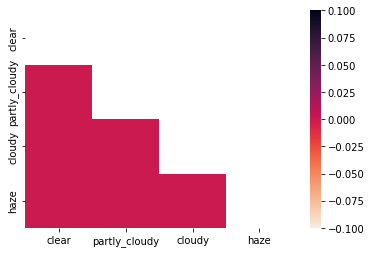

In [20]:
# concurrent matrix of atmospheric condition tags
atm_tags_concurrent_matrix = get_concurrent_matrix(atm_condition_tags) 
atm_tags_concurrent_matrix

No overlap in atmospheric condition

,primary,water,habitation,agriculture,road,cultivation,bare_ground
primary,37513,7001,3469,11972,7728,4455,683
water,7001,7411,915,2712,2125,868,206
habitation,3469,915,3660,2737,2786,895,163
agriculture,11972,2712,2737,12315,6034,3377,225
road,7728,2125,2786,6034,8071,1294,323
cultivation,4455,868,895,3377,1294,4477,89
bare_ground,683,206,163,225,323,89,862


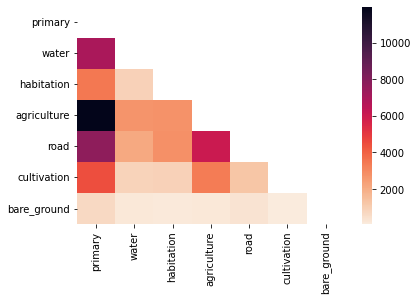

In [21]:
# concurrent matrix of common land cover tags
get_concurrent_matrix(common_land_cover_tags) 

'primary' and 'agriculture' seems to have the most overlap amongst common_land_cover_tags

,blooming,selective_logging,artisinal_mine,slash_burn,conventional_mine,blow_down
blooming,332,7,0,2,0,1
selective_logging,7,340,6,2,0,1
artisinal_mine,0,6,339,0,4,0
slash_burn,2,2,0,209,0,2
conventional_mine,0,0,4,0,100,0
blow_down,1,1,0,2,0,98


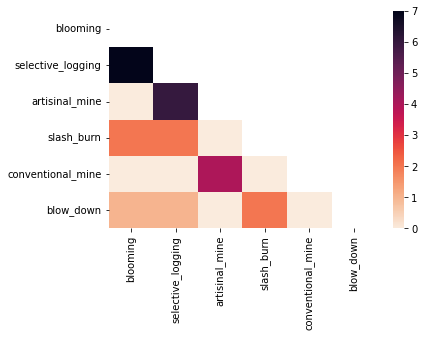

In [22]:
# concurrent matrix of rare land cover
get_concurrent_matrix(rare_land_cover_tags) 


Fairly overlaps but 'selective_logging' and 'blooming' seems to have the most overlap amongst 'rare_land_cover_tags'

,clear,partly_cloudy,blooming,cultivation,haze,agriculture,water,habitation,selective_logging,artisinal_mine,cloudy,primary,slash_burn,conventional_mine,bare_ground,road,blow_down
clear,28431,0,311,3527,0,9150,5502,3090,308,307,0,27668,173,70,747,6295,85
partly_cloudy,0,7261,17,748,0,2493,1295,441,27,27,0,7175,33,28,74,1382,13
blooming,311,17,332,35,4,32,16,4,7,0,0,332,2,0,3,10,1
cultivation,3527,748,35,4477,202,3377,868,895,58,18,0,4455,126,4,89,1294,8
haze,0,0,4,202,2697,672,613,129,5,5,0,2670,3,2,41,394,0
agriculture,9150,2493,32,3377,672,12315,2712,2737,65,38,0,11972,119,24,225,6034,22
water,5502,1295,16,868,613,2712,7411,915,49,299,0,7001,24,26,206,2125,3
habitation,3090,441,4,895,129,2737,915,3660,13,29,0,3469,41,36,163,2786,3
selective_logging,308,27,7,58,5,65,49,13,340,6,0,340,2,0,13,151,1
artisinal_mine,307,27,0,18,5,38,299,29,6,339,0,324,0,4,40,110,0


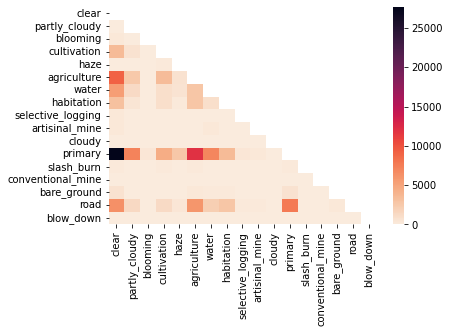

In [23]:
# concurrent matrix of all tags
get_concurrent_matrix(unique_labels) 

Not much overlaps amongst all tags, but 'primary' and 'clear' seems to have the most ovelap

In [24]:
# let's check if indeed every image must have one atmospheric condition tag
total_atm_tags = np.matmul(np.array(atm_tags_concurrent_matrix), (np.ones((4, 1)))).sum()
print(total_atm_tags)
total_atm_tags == train_classes.shape[0]

40478.0


False

In [25]:
# the above cell returned false, it seems only one image doesn't contain any atmospheric condition.let's check it out
image_atm_tags_df = train_classes.loc[:, ['image_name']+atm_condition_tags] 
image_without_atm_df = image_atm_tags_df.loc[image_atm_tags_df.sum(axis=1) == 0]
image_without_atm_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,image_name,clear,partly_cloudy,cloudy,haze
24448,train_24448.jpg,0,0,0,0


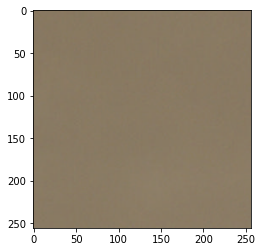

In [26]:
# let's view this image without any atmospheric condition
image_without_atm_name = image_without_atm_df.loc[24448, 'image_name']
image_without_atm = io.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}'.format( \
                                                                                    image_without_atm_name))
plt.imshow(image_without_atm)

In [27]:
# let's checkout the tags associated with this image above
train_classes_df[train_classes_df['image_name'] == image_without_atm_name[:-4]]

,image_name,tags
24448,train_24448,water



The data says it is water, does it look like one? Perhaps it is a dirty water or some random noise!

In [28]:
# let's view a sample image say 'train_10.jpg' 
image_number = 10
sample_img = io.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))
r, g, b = sample_img[:, :, 0], sample_img[:, :, 1], sample_img[:, :, 2]
sample_img.shape

(256, 256, 3)

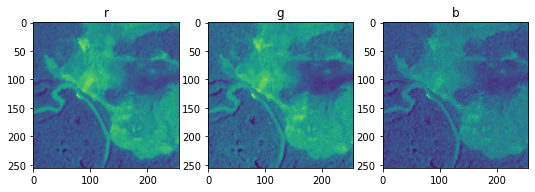

In [29]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for ind, (img, channel) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
    a = fig.add_subplot(1, 4, ind+1)
    a.set_title(channel)
    plt.imshow(img)
    
# displaying the red, green and blue channels seperately

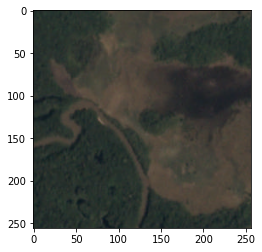

In [30]:
# displaying all channels at once
plt.imshow(sample_img) 

In [31]:
y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=45, horizontal_flip=True, \
                                            vertical_flip=True, zoom_range=0.2)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [32]:
# X is an iterable, It contains 317 batches, each batch contains 128 images and labels because 
#40479 / 128 is 316 remainder 31 each image is of shape (128, 128, 3), each label is of shape (17, )

# let's abitrarily view an image
x109 = X[0][0][109] # first batch, images, 109th image
y109 = X[0][1][109] # first batch, labels, 109th label
print("each image's shape is {}".format(x109.shape))
print("each label's shape is {}".format(y109.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (128, 128, 3)
each label's shape is (17,)
we have 317 batches
each batch has 128 images/labels
40479/128 is 316.24, so the last batch will have 31 images/labels


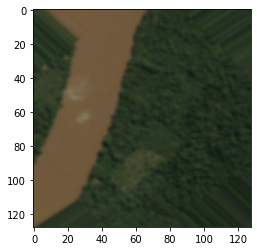

In [33]:
# divided by 255 so the image can be displayed
plt.imshow(x109/255) 

In [34]:
# importing useful deep learning libraries

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [35]:
# defining a function to calculate fbeta score

def fbeta(ytrue, ypred, beta=2, threshold=0.2, epsilon=1e-7):
    # threshold is set to 0.2 to maximize recall since f2 score is recall biased
    # epsilon is set to 1e-7 to avoide Nan values due to zero division
    
    beta_squarred = float(beta)**2
    
    ytrue = tf.cast(ytrue, tf.float32) # casts ytrue as a float
    # convert ypred to bool, then to float
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32) 
    
    tp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(3.0)), tf.float32), axis=1) 
    fp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(1.0)), tf.float32), axis=1)
    fn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(2.0)), tf.float32), axis=1)

    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    fb = (beta_squarred+1) * precision * recall / (precision*beta_squarred + recall + epsilon)
  
    return fb

In [36]:
# creating a function to calculate multi-label accuracy 

def multi_label_acc(ytrue, ypred, threshold=0.2, epsilon=1e-7):
    # threshold is set to 0.2 to maximize recall since f2 score is recall biased
    # epsilon is set to 1e-7 to avoide Nan values due to zero division
    
    ytrue = tf.cast(ytrue, tf.float32) # casts ytrue as a float
    # convert ypred to bool, then to float
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32) 
    
    tp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(3.0)), tf.float32), axis=1) 
    fp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(1.0)), tf.float32), axis=1)
    fn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(2.0)), tf.float32), axis=1)
    tn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(0.0)), tf.float32), axis=1)
    
    acc = (tp+tn) / (tp+fp+fn+tn+epsilon)  
    
    return acc

In [37]:
# creating a function to build a sequential model

def build_model():
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [38]:
# initializing callbacks
early_stopping = EarlyStopping(monitor='val_fbeta', patience=10, mode='max', verbose=1)
reduced_lr = ReduceLROnPlateau(monitor='val_fbeta', patience=3, cool_down=2, mode='max')
save_best_check_point = ModelCheckpoint(filepath='best_model2.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [39]:
# initializing an image data generator object with a validation split of 80:20
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, \
                                            vertical_flip=True, validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [40]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [41]:
model1 = build_model() # building a sequential model for training

# fitting the model
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=50, callbacks=[early_stopping, reduced_lr, save_best_check_point], )

2022-09-20 12:39:16.007399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 12:39:16.095697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 12:39:16.096489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 12:39:16.098157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-09-20 12:39:20.855043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-20 12:39:24.770448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


253/253 [==============================] - 381s 1s/step - loss: 0.1540 - multi_label_acc: 0.9136 - fbeta: 0.8569 - val_loss: 0.1170 - val_multi_label_acc: 0.9435 - val_fbeta: 0.8987
Epoch 2/50
253/253 [==============================] - 248s 979ms/step - loss: 0.1108 - multi_label_acc: 0.9447 - fbeta: 0.9023 - val_loss: 0.1132 - val_multi_label_acc: 0.9428 - val_fbeta: 0.9007
Epoch 3/50
253/253 [==============================] - 248s 980ms/step - loss: 0.1037 - multi_label_acc: 0.9483 - fbeta: 0.9099 - val_loss: 0.1026 - val_multi_label_acc: 0.9492 - val_fbeta: 0.9107
Epoch 4/50
253/253 [==============================] - 244s 965ms/step - loss: 0.1005 - multi_label_acc: 0.9501 - fbeta: 0.9127 - val_loss: 0.1012 - val_multi_label_acc: 0.9530 - val_fbeta: 0.9126
Epoch 5/50
253/253 [==============================] - 245s 967ms/step - loss: 0.0983 - multi_label_acc: 0.9509 - fbeta: 0.9143 - val_loss: 0.0957 - val_multi_label_acc: 0.9523 - val_fbeta: 0.9171
Epoch 6/50
253/253 [==============

The model training lasted for approximately 1hr 20mins with a best val_fbeta score of 0.9256. Early stopping was triggered after the 28th epoch.

In [42]:
# building a sequential model for testing
model2 = build_model()

#loading in the weights of the trained model
model2.load_weights('best_model2.hdf5')

In [43]:
# adding .jpg extension to 'image_name' in sample_submission data
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [44]:
# selecting the first 40669 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test.jpg folder
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [45]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator()

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [46]:
# reseting the generator to be sure of avoiding shuffling
test_gen1.reset() 
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) 
# predicts the first 40669 images in the sample submission data frame
                                                                

318/318 [==============================] - 238s 749ms/step


In [47]:
# storing the filenames (images names) of the first 40669 images in the sample submission dataframe as ordered in the prediction as a variable.
test_file_names1 = test_gen1.filenames 
# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.2]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear cultivation agriculture primary
4,test_4.jpg,partly_cloudy cloudy primary


In [48]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from test-additional.jpg folder
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [49]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator()

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [50]:
# reseting the generator to be sure of avoiding shuffling predicts the remaining images in the sample submission dataframe
test_gen2.reset() 
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) 

161/161 [==============================] - 122s 762ms/step


In [51]:
# storing the filenames (kmages names) of the remaining images names in the sample sumbmission dataframe as ordered in the prediction as a variable
test_file_names2 = test_gen2.filenames 
# converting the predictions of the remaining images to tag names
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.2]), axis=1)

# converting the predictions of the remaining to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,partly_cloudy agriculture primary road
2,file_10.jpg,clear haze agriculture water primary road
3,file_100.jpg,clear water primary
4,file_1000.jpg,clear primary


In [53]:
final_result = pd.concat([result1, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear cultivation agriculture primary
4,test_4.jpg,partly_cloudy cloudy primary


In [54]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [55]:
# removing the .jpg extension from 'iamge_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear cultivation agriculture primary
4,test_4,partly_cloudy cloudy primary


In [62]:
final_result.to_csv('My_Hamoye_Kaggle_competiton.csv', index=False) # saving the predictions

In [59]:
!ls '/kaggle/input'

planets-dataset


In [ ]:
data = pd.read_csv("", error_bad_lines=False)
data